In [1]:
%config IPCompleter.greedy=True
#import findspark
#findspark.init()
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, explode
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
import socket
import time

In [2]:
conf=SparkConf().setMaster("local[*]").setAppName("Recommendation")
sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession.builder.getOrCreate()

In [3]:
books = spark.read.csv("Books.csv",header=True)
ratings = spark.read.csv("Ratings.csv",header=True)
users = spark.read.csv("Users.csv", header=True)

books=books.select("ISBN","Book-Title","Book-Author","Year-Of-Publication","Publisher")

bookRating = books.join(ratings, on="ISBN")
bookRatingUsers = bookRating.join(users, on="User-ID")
sqlDf = bookRatingUsers.withColumnRenamed("User-ID","UserID") \
             .withColumnRenamed("Book-Title","BookTitle")\
             .withColumnRenamed("Book-Author","BookAuthor")\
             .withColumnRenamed("Year-Of-Publication","YearOfPublication")\
             .withColumnRenamed("Book-Rating","BookRating")
del bookRating, bookRatingUsers, books, ratings, users


sqlDf = sqlDf.withColumn("UserID", col("UserID").cast("integer")) \
             .withColumn("ISBN", col("ISBN").cast("integer")) \
             .withColumn("BookRating", col("BookRating").cast("float")) \
             .withColumn("Age", col("Age").cast("integer")) \
             .withColumn("YearOfPublication", col("YearOfPublication").cast("integer"))


sqlDf = sqlDf.filter("Age > 10").filter("Age < 100")
sqlDf = sqlDf.filter("YearOfPublication > 1920").filter("YearOfPublication < 2022")
sqlDf = sqlDf.dropna(subset=("UserID","ISBN","BookTitle","BookAuthor","YearOfPublication","Publisher","BookRating","Location","Age"))


pdDf = sqlDf.toPandas()
sqlDf.show(25)

+------+----------+--------------------+-------------------+-----------------+--------------------+----------+--------------------+---+
|UserID|      ISBN|           BookTitle|         BookAuthor|YearOfPublication|           Publisher|BookRating|            Location|Age|
+------+----------+--------------------+-------------------+-----------------+--------------------+----------+--------------------+---+
|100009|  60392452|Stupid White Men ...|      Michael Moore|             2002|         Regan Books|       8.0|victoria, british...| 49|
|100009|  60977337|Downsize This! Ra...|      Michael Moore|             1997|           Perennial|       9.0|victoria, british...| 49|
|100009| 312981589|Robert Ludlum's T...|      Robert Ludlum|             2002|St. Martin's Pape...|       6.0|victoria, british...| 49|
|100009| 345391055|          Disclosure|   Michael Crichton|             1994|    Ballantine Books|       0.0|victoria, british...| 49|
|100009| 385504209|   The Da Vinci Code|        

In [4]:
for conf in sc.getConf().getAll():
    print(conf)
    
print("IP Address: " + socket.gethostbyname(socket.gethostname()))

('spark.sql.warehouse.dir', 'file:/home/dilan/Masaüstü/data/spark-warehouse')
('spark.app.name', 'Recommendation')
('spark.rdd.compress', 'True')
('spark.serializer.objectStreamReset', '100')
('spark.master', 'local[*]')
('spark.submit.pyFiles', '')
('spark.executor.id', 'driver')
('spark.driver.port', '41623')
('spark.submit.deployMode', 'client')
('spark.driver.host', '10.0.2.15')
('spark.app.id', 'local-1642534855339')
('spark.ui.showConsoleProgress', 'true')
('spark.app.startTime', '1642534852687')
IP Address: 127.0.1.1


In [5]:
for i in sqlDf.take(25):
    print("User ID: " + str(i["UserID"]) + " |ISBN: " + str(i["ISBN"]) + " |Book Title: " + i["BookTitle"] + " |Book Author: " + i["BookAuthor"] + " |Year Of Publication: " + str(i["YearOfPublication"]) + " |Publisher: " + i["Publisher"] + " |Book Rating: " + str(i["BookRating"]) + " |Location: " + i["Location"] + " |Age: " + str(i["Age"]))

User ID: 100009 |ISBN: 60392452 |Book Title: Stupid White Men ...and Other Sorry Excuses for the State of the Nation! |Book Author: Michael Moore |Year Of Publication: 2002 |Publisher: Regan Books |Book Rating: 8.0 |Location: victoria, british columbia, canada |Age: 49
User ID: 100009 |ISBN: 60977337 |Book Title: Downsize This! Random Threats from an Unarmed American |Book Author: Michael Moore |Year Of Publication: 1997 |Publisher: Perennial |Book Rating: 9.0 |Location: victoria, british columbia, canada |Age: 49
User ID: 100009 |ISBN: 312981589 |Book Title: Robert Ludlum's The Cassandra Compact (A Covert-One Novel) |Book Author: Robert Ludlum |Year Of Publication: 2002 |Publisher: St. Martin's Paperbacks |Book Rating: 6.0 |Location: victoria, british columbia, canada |Age: 49
User ID: 100009 |ISBN: 345391055 |Book Title: Disclosure |Book Author: Michael Crichton |Year Of Publication: 1994 |Publisher: Ballantine Books |Book Rating: 0.0 |Location: victoria, british columbia, canada |Ag

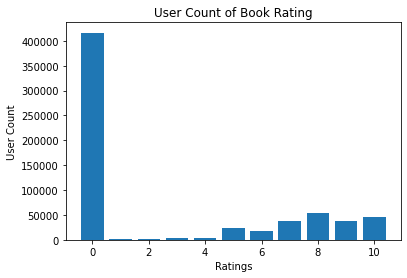

In [6]:
count = pdDf.groupby("BookRating")["UserID"].count().reset_index()
plt.figure()
plt.title("User Count of Book Rating")
plt.bar(count["BookRating"], count["UserID"])
plt.xlabel("Ratings")
plt.ylabel("User Count")
del count

<Figure size 432x288 with 0 Axes>

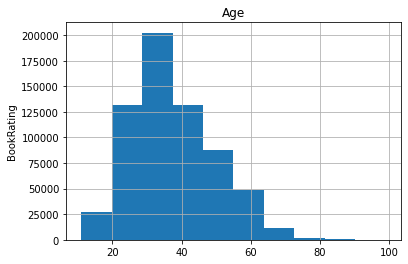

In [7]:
count = pdDf.groupby("Age")["BookRating"].count().reset_index()
plt.figure()
count.hist("Age", weights=count["BookRating"] )
plt.ylabel("BookRating")
plt.show()
del count

<Figure size 432x288 with 0 Axes>

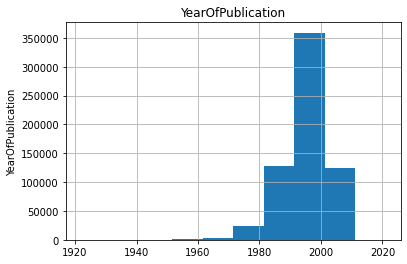

In [8]:
count = pdDf.groupby("YearOfPublication")["ISBN"].count().reset_index()
plt.figure()
count.hist("YearOfPublication", weights=count["ISBN"] )
plt.ylabel("YearOfPublication")
plt.show()
del count

In [9]:
ratings = sqlDf.\
    drop("BookTitle").\
    drop("BookAuthor").\
    drop("YearOfPublication").\
    drop("Publisher").\
    drop("Location").\
    drop("Age")

ratings.show(10)

+------+---------+----------+
|UserID|     ISBN|BookRating|
+------+---------+----------+
|100009| 60392452|       8.0|
|100009| 60977337|       9.0|
|100009|312981589|       6.0|
|100009|345391055|       0.0|
|100009|385504209|       8.0|
|100009|399132414|       0.0|
|100009|425179230|       0.0|
|100009|440224675|       0.0|
|100009|441172717|       9.0|
|100009|449219364|       0.0|
+------+---------+----------+
only showing top 10 rows



In [10]:
(trainDf, testDf) = ratings.randomSplit([0.7, 0.3])
train = trainDf.rdd
test = testDf.rdd

ranks = [10,50,200]
iterations = [5,10,15]
lambdas = [0.01,0.1]
MSEs = []

In [ ]:
for iterationIndex in range(len(iterations)):
    for rankIndex in range(len(ranks)):
        for lambdaIndex in range(len(lambdas)):
            time.sleep(5)
            model = ALS.train(ratings=train, rank = ranks[rankIndex], iterations = iterations[iterationIndex], lambda_ = lambdas[lambdaIndex], seed = 5106)
            predictions = model.predictAll(test.map(lambda r: ((r[0], r[1])))).map(lambda r: ((r[0], r[1]), r[2]))
            ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            
            mse = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            print("Rank: " + str(ranks[rankIndex]) + " Iteration: " + str(iterations[iterationIndex]) + " Lambda: " + str(lambdas[lambdaIndex]))
            print(str(mse))
            MSEs.append(["Rank: " + str(ranks[rankIndex]) + "Iteration: " + str(iterations[iterationIndex]) + "Lambda: " + str(lambdas[lambdaIndex]), mse])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [ ]:
def cosineSimilarity(item_id,a,b):
    dot = np.dot(a,b)
    norma= np.linalg.norm(a)
    normb= np.linalg.norm(b)
    cos = dot/(norma * normb)
    return item_id, cos

In [ ]:
titles = sqlDf.rdd.map(lambda line: line[:2])\
                    .map(lambda x: (int (x[0]), x[1]))\
                    .collectAsMap()

In [ ]:
item_id=60392452
item_vector = model.productFeatures().lookup(item_id)[0]
item_vector

In [ ]:
cosineSimilarity(item_id, item_vector, item_vector)

In [ ]:
sims = model.productFeatures().map(lambda data: cosineSimilarity(data[0],data[1]),item_vector)

In [ ]:
sims.top(10,key=lambda x: x[1])